In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# Set a fixed seed for reproducibility
torch.manual_seed(66)

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")

Device being used: cuda


In [3]:
def prepare_data(batch_size=128, image_size=64):
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])
    dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print("Data Preparation Complete")
    print(f"Number of training batches: {len(dataloader)}")
    return dataloader

# Prepare the data
dataloader = prepare_data()

Files already downloaded and verified
Data Preparation Complete
Number of training batches: 391


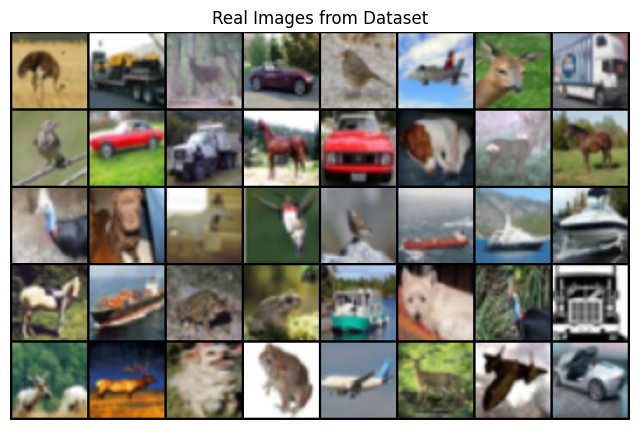

In [4]:
def display_real_images(dataloader, num_images=40):
   
    real_images, _ = next(iter(dataloader))  # Get a batch of real images
    real_images = real_images * 0.5 + 0.5  # Undo normalization to [0, 1]
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Real Images from Dataset")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_images[:num_images], padding=2, normalize=False), (1, 2, 0)))
    plt.show()

# Show sample real images
display_real_images(dataloader)

In [5]:
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Initialize Generator
nz, ngf = 100, 64  # Latent vector size and generator feature size
netG = Generator(nz, ngf).to(device)
print("Generator Model Summary:")
print(netG)

Generator Model Summary:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Initialize Discriminator
ndf = 64  # Discriminator feature size
netD = Discriminator(ndf).to(device)
print("Discriminator Model Summary:")
print(netD)

Discriminator Model Summary:
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [7]:
def initialize_training(lr=0.0002, beta1=0.5):
   
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)  # Fixed noise for visualization
    print(f"Training components initialized on device: {device}")
    return criterion, optimizerG, optimizerD, fixed_noise

# Initialize training components
criterion, optimizerG, optimizerD, fixed_noise = initialize_training()

Training components initialized on device: cuda


In [8]:
!pip install torchmetrics[image]
!pip install torch-fidelity


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [9]:
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.nn as nn
import torch

# Weight Initialization Function
def weights_init(m):
    """
    Initializes weights as per DCGAN guidelines.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Training Function
def train_dcgan_with_fid(netG, netD, dataloader, criterion, optimizerG, optimizerD, fixed_noise, num_epochs=25):
   
    real_label = 0.9  # Label smoothing for real images
    fake_label = 0.0
    G_losses, D_losses, FID_scores = [], [], []
    fid = FrechetInceptionDistance(feature=2048).to(device)  # Initialize FID metric

    print("Starting Training...\n")
    for epoch in range(num_epochs):
        for i, (data, _) in enumerate(dataloader):
            ### Train Discriminator ###
            netD.zero_grad()
            real_images = data.to(device)
            b_size = real_images.size(0)
            labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)  # Label smoothing
            output = netD(real_images).view(-1)
            lossD_real = criterion(output, labels)
            lossD_real.backward()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            labels.fill_(fake_label)
            output = netD(fake_images.detach()).view(-1)  # Detach fake images for discriminator update
            lossD_fake = criterion(output, labels)
            lossD_fake.backward()
            optimizerD.step()

            ### Train Generator ###
            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)  # Recompute noise
            fake_images = netG(noise)  # Recompute fake images
            labels.fill_(real_label)  # Real label for generator's target
            output = netD(fake_images).view(-1)
            lossG = criterion(output, labels)
            lossG.backward()  # No need for retain_graph here
            optimizerG.step()

            # Record losses
            D_losses.append(lossD_real.item() + lossD_fake.item())
            G_losses.append(lossG.item())

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                      f"Loss_D: {D_losses[-1]:.4f}, Loss_G: {G_losses[-1]:.4f}")

        ### FID Calculation ###
        fid.reset()  # Clear previous epoch data

        # Add real images to FID metric
        for real_batch, _ in dataloader:
            real_batch = (real_batch * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
            real_batch = real_batch.to(torch.uint8).to(device)  # Convert to uint8 and move to device
            fid.update(real_batch, real=True)

        # Add fake images to FID metric
        with torch.no_grad():
            for _ in range(len(dataloader)):
                fake_batch = netG(torch.randn(b_size, nz, 1, 1, device=device))
                fake_batch = (fake_batch * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
                fake_batch = fake_batch.to(torch.uint8).to(device)  # Convert to uint8 and move to device
                fid.update(fake_batch, real=False)

        # Compute FID score
        fid_score = fid.compute().item()
        FID_scores.append(fid_score)

        print(f"End of Epoch [{epoch+1}/{num_epochs}] - Loss_D: {D_losses[-1]:.4f}, "
              f"Loss_G: {G_losses[-1]:.4f}, FID: {fid_score:.4f}\n")

    print("Training Complete!\n")
    return G_losses, D_losses, FID_scores

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)

# Initialize training components
nz = 100  # Latent space size
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
fixed_noise = torch.randn(64, nz, 1, 1, device=device)  # Fixed noise for consistent visualization

# Train the model
G_losses, D_losses, FID_scores = train_dcgan_with_fid(netG, netD, dataloader, criterion, optimizerG, optimizerD, fixed_noise)


Starting Training...

Epoch [1/25] Batch [0/391] Loss_D: 1.3950, Loss_G: 0.7174
Epoch [1/25] Batch [100/391] Loss_D: 0.3450, Loss_G: 3.7378
Epoch [1/25] Batch [200/391] Loss_D: 0.3314, Loss_G: 4.9733
Epoch [1/25] Batch [300/391] Loss_D: 0.4188, Loss_G: 5.8292
End of Epoch [1/25] - Loss_D: 1.1935, Loss_G: 5.3836, FID: 311.1018

Epoch [2/25] Batch [0/391] Loss_D: 0.7533, Loss_G: 4.5908
Epoch [2/25] Batch [100/391] Loss_D: 1.6753, Loss_G: 4.4624
Epoch [2/25] Batch [200/391] Loss_D: 0.9063, Loss_G: 3.3919
Epoch [2/25] Batch [300/391] Loss_D: 0.7887, Loss_G: 1.8578
End of Epoch [2/25] - Loss_D: 0.8553, Loss_G: 3.4440, FID: 293.2973

Epoch [3/25] Batch [0/391] Loss_D: 0.7115, Loss_G: 2.1706
Epoch [3/25] Batch [100/391] Loss_D: 0.8956, Loss_G: 1.8204
Epoch [3/25] Batch [200/391] Loss_D: 1.0703, Loss_G: 2.7701
Epoch [3/25] Batch [300/391] Loss_D: 0.8670, Loss_G: 2.1992
End of Epoch [3/25] - Loss_D: 1.2830, Loss_G: 2.8187, FID: 221.1679

Epoch [4/25] Batch [0/391] Loss_D: 0.9866, Loss_G: 1.3936

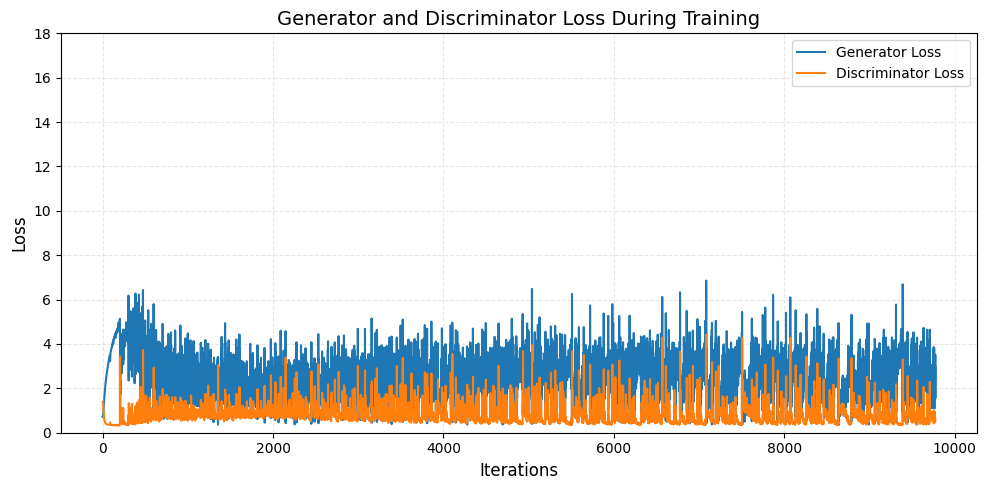

In [10]:
def plot_loss_graphs(G_losses, D_losses):
    
    plt.figure(figsize=(10, 5))  # Set figure size
    plt.plot(G_losses, label="Generator Loss")  # Generator loss in blue
    plt.plot(D_losses, label="Discriminator Loss")  # Discriminator loss in orange
    
    # Add axis labels and title
    plt.xlabel("Iterations", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Generator and Discriminator Loss During Training", fontsize=14)
    
    # Customize y-axis ticks
    plt.yticks(range(0, 19, 2))  # Set y-axis ticks from 0 to 12 with steps of 2
    
    # Add grid, legend, and layout adjustments
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage
plot_loss_graphs(G_losses, D_losses)


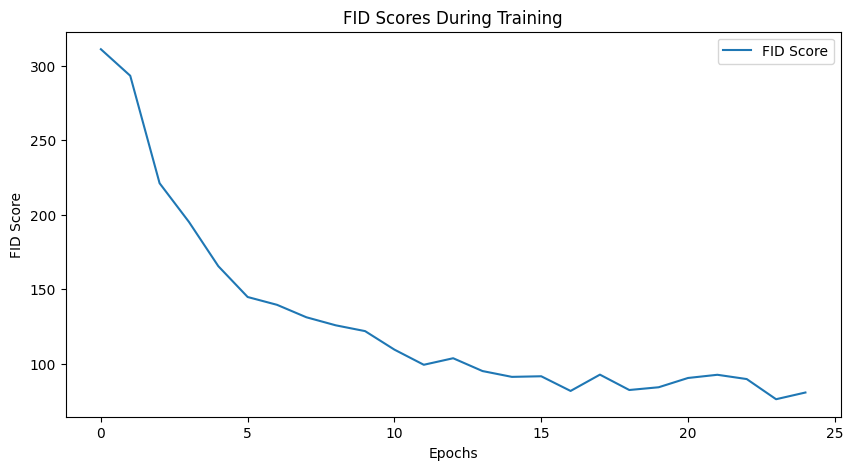

In [11]:
def plot_fid_scores(FID_scores):
    
    plt.figure(figsize=(10, 5))
    plt.title("FID Scores During Training")
    plt.plot(FID_scores, label="FID Score")
    plt.xlabel("Epochs")
    plt.ylabel("FID Score")
    plt.legend()
    plt.show()

# Plot FID scores
plot_fid_scores(FID_scores)


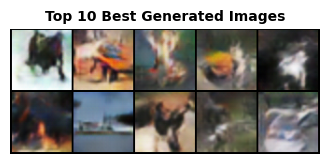

In [18]:
def display_best_fake_images(netG, netD, fixed_noise, num_best=10):
    """
    Displays the top `num_best` fake images in a 2x5 grid.

    Args:
    - netG: Trained generator network.
    - netD: Trained discriminator network.
    - fixed_noise: Latent vectors used for generation.
    - num_best: Number of best fake images to display (default: 10).

    Returns:
    - None
    """
    # Generate fake images using the generator
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()  # Fake images on CPU
        fake_images_gpu = netG(fixed_noise).detach()  # Fake images on GPU for scoring

    # Get discriminator scores for the generated fake images
    scores = netD(fake_images_gpu).view(-1).detach().cpu().numpy()  # Move scores to CPU for sorting
    sorted_indices = np.argsort(scores)[::-1][:num_best]  # Sort scores in descending order and get top `num_best`

    # Select the best fake images based on discriminator scores
    best_fake_images = torch.stack([fake_images[i] for i in sorted_indices])  # Use stack to avoid stride issues

    # Display the best fake images in a grid (2 rows, 5 columns)
    grid = torchvision.utils.make_grid(best_fake_images, nrow=5, padding=2, normalize=True)

    # Plot the grid
    plt.figure(figsize=(4, 4))  # Adjust figure size to make the grid look better
    plt.axis("off")
    plt.title(f"Top {num_best} Best Generated Images", fontsize=10, fontweight="bold")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

# Example usage
display_best_fake_images(netG, netD, fixed_noise, num_best=10)


In [13]:
def display_real_and_fake_images(dataloader, netG, fixed_noise, num_images=16):
    
    # Fetch a batch of real images
    real_images, _ = next(iter(dataloader))  # Get a batch of real images
    real_images = real_images[:num_images] * 0.5 + 0.5  # Undo normalization to [0, 1]
    
    # Generate a batch of fake images
    with torch.no_grad():
        fake_images = netG(fixed_noise[:num_images]).detach().cpu() * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Create the figure and display both sets of images
    plt.figure(figsize=(12, 6))

    # Display real images on the left
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_images, padding=2, normalize=False), (1, 2, 0)))

    # Display fake images on the right
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake_images, padding=2, normalize=False), (1, 2, 0)))

    plt.show()


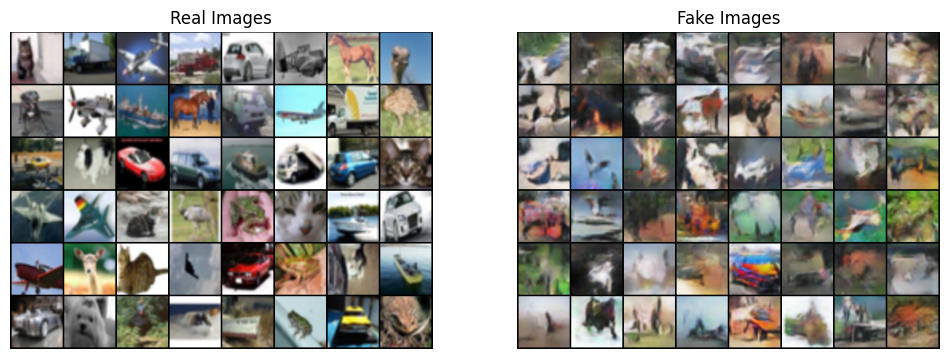

In [14]:
display_real_and_fake_images(dataloader, netG, fixed_noise, num_images=48)
